<a href="https://colab.research.google.com/github/Jack3690/INSIST/blob/main/notebooks/Galaxy_Clump_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install astroquery --quiet
!pip install photutils --quiet
!pip install insist-pista --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.9/887.9 kB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 82.7 MB/s eta 0:00:00


In [34]:
from astropy.stats import SigmaClip, gaussian_fwhm_to_sigma
import astropy.units as u
from astropy.wcs import WCS
from astropy.modeling import models, fitting
from astropy.convolution import Gaussian2DKernel,convolve

from astroquery.skyview import SkyView

from photutils.background import Background2D, MedianBackground,SExtractorBackground
from photutils.segmentation import SourceCatalog, deblend_sources, detect_sources

from scipy.interpolate import interp2d
from skimage import io, feature
from skimage.measure import label, regionprops

from scipy.optimize import curve_fit
from scipy.signal import fftconvolve

import skimage
from skimage import io, feature, filters, morphology, segmentation, restoration, measure

import matplotlib
import matplotlib.colors as col
import matplotlib.pyplot as plt

import numpy as np
import pista as pt

In [29]:
data_path = pt.data_dir

In [7]:
path = SkyView.get_images(position = 'UGC 5272', radius = 0.05*u.degree,
                          survey = ['GALEX Near UV'])

In [10]:
data = path[0][0].data.copy()
wcs = WCS(path[0][0].header)

In [11]:
sigma_clip    = SigmaClip(sigma= 5)
bkg_estimator = SExtractorBackground()
bkg           = Background2D(data, (5, 5), filter_size = (3, 3),
                sigma_clip=sigma_clip, bkg_estimator = bkg_estimator)

bkg_image     = bkg.background

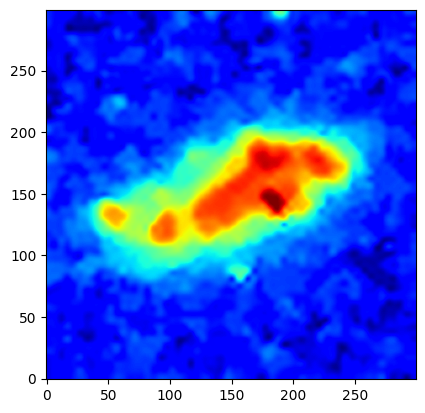

In [15]:
plt.imshow(bkg_image , origin = 'lower', cmap = 'jet', norm = col.LogNorm())

In [16]:
FWHM   = 4.2/(wcs.wcs.cdelt[1]*3600) # FWHM of the source image in pixels

sigma  = FWHM*gaussian_fwhm_to_sigma

kernel = Gaussian2DKernel(sigma)
kernel.normalize()

deconvolved_data = restoration.richardson_lucy(data.astype(float), kernel.array,
                                               num_iter = 20)

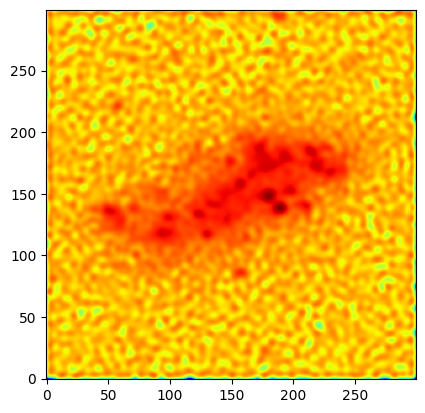

In [17]:
plt.imshow(deconvolved_data, origin = 'lower',cmap = 'jet' , norm=col.LogNorm())

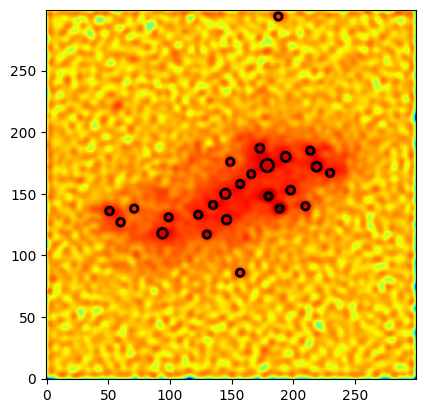

In [18]:
# Source Image
galaxy_img = deconvolved_data

# Smoothed image
image_data = deconvolved_data

# Set the parameters for blob detection
min_sigma = 3
max_sigma = 5
num_sigma = 20
threshold = 0.02

# Detect blobs in the image
blobs = feature.blob_log(image_data, min_sigma=min_sigma, max_sigma=max_sigma,
                 num_sigma=num_sigma, threshold=threshold)

# Plot the image with the detected blobs
fig, ax = plt.subplots()
ax.imshow(image_data, origin="lower", cmap = 'jet', norm = col.LogNorm())
for blob in blobs:
    y, x, r = blob
    c = plt.Circle((x, y), r, color="black", linewidth=2, fill=False)
    ax.add_patch(c)
plt.show()

In [19]:
s_ps_scale = (wcs.wcs.cdelt[1]*3600)
out_ps_scale = 0.1
scale = s_ps_scale/out_ps_scale
out_size = int(scale*data.shape[0])

In [ ]:
# Interpolated Galaxy Diffused Image
x = np.arange(0,data.shape[0],1)/data.shape[1]
y = np.arange(0,data.shape[1],1)/data.shape[1]

func = interp2d(x,y,bkg_image )

x_n = np.arange(0,out_size,1)/out_size
y_n = np.arange(0,out_size,1)/out_size

bkg_img = func(x_n,y_n)

In [25]:
clumps = []
y_in, x_in = np.mgrid[0:galaxy_img.shape[0], 0:galaxy_img.shape[1]]
y_out, x_out =  np.mgrid[0:out_size, 0:out_size]
sim_img = 0


for blob in blobs:
    y, x, r = blob
    # Create a circular mask around the blob
    y, x, r = int(y), int(x), int(r)
    mask = np.zeros_like(galaxy_img)
    rr, cc = skimage.draw.disk((y, x), r, shape=mask.shape)
    mask[rr, cc] = 1

    # Extract the pixels within the mask
    masked_image = galaxy_img*mask

    # Define the function to fit to the masked pixels

    init = models.Gaussian2D(x_mean= x,
                             y_mean= y,
                             x_stddev=r/2,
                             y_stddev=r/2
                            )
    fit  = fitting.LevMarLSQFitter()

    model = fit(init,x_in, y_in, masked_image)
    model.x_mean*=scale
    model.y_mean*=scale
    model.x_stddev*=scale
    model.y_stddev*=scale

    sim_img += model(x_out,y_out)

In [31]:
psf = np.load(f'{data_path}/PSF/INSIST/off_axis_poppy.npy')

In [ ]:
x = np.arange(0,data.shape[0],1)/data.shape[1]
y = np.arange(0,data.shape[1],1)/data.shape[1]

func = interp2d(x,y,bkg_image )

x_n = np.arange(0,out_size,1)/out_size
y_n = np.arange(0,out_size,1)/out_size

bkg_img = func(x_n,y_n)

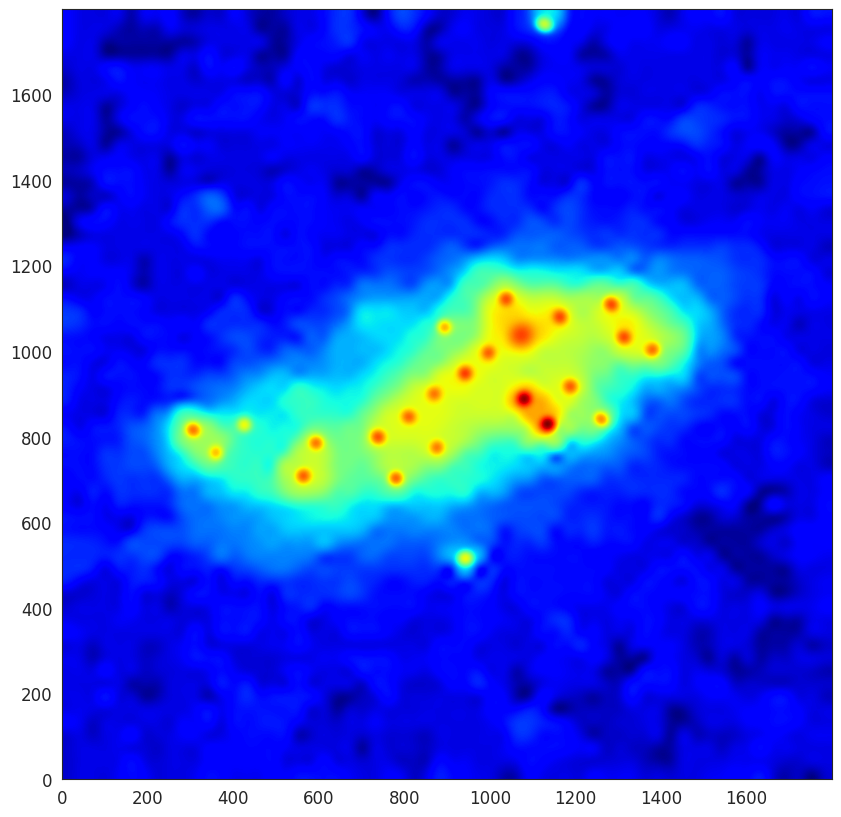

In [33]:
plt.imshow(sim_img+ bkg_img, origin = 'lower', cmap = 'jet', norm = col.LogNorm())

In [35]:
conv_img = fftconvolve(sim_img + bkg_img, psf, mode = 'same')

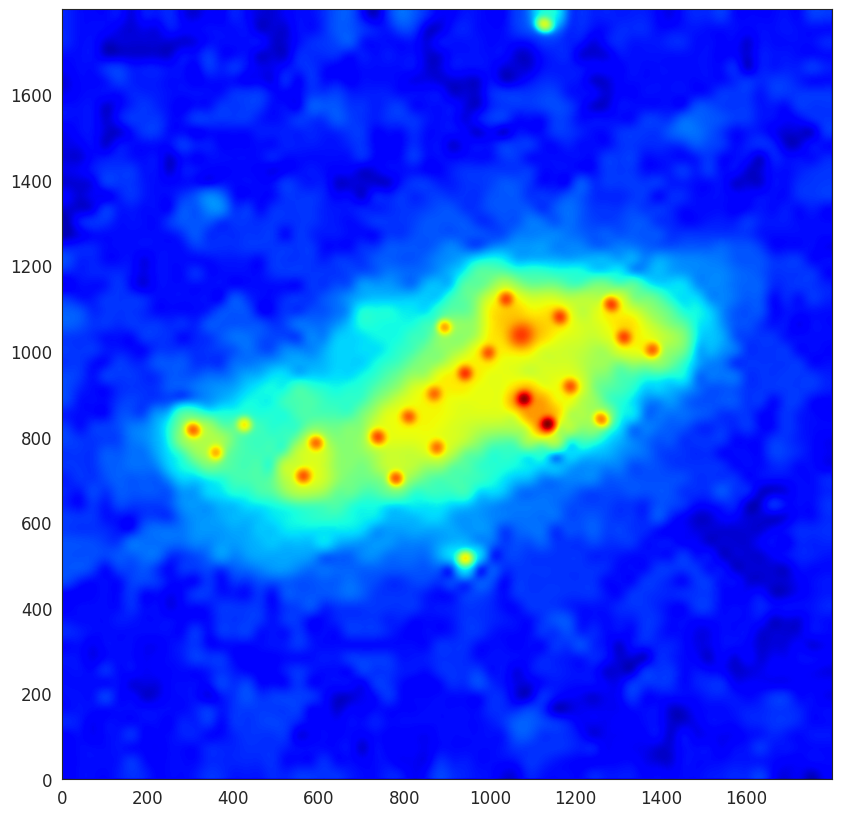

In [36]:
plt.imshow(conv_img, origin = 'lower', cmap = 'jet', norm = col.LogNorm())

In [37]:
matplotlib.rcParams['font.size'] = 20

Text(0.5, 1.0, 'Convolved with INSIST PSF')

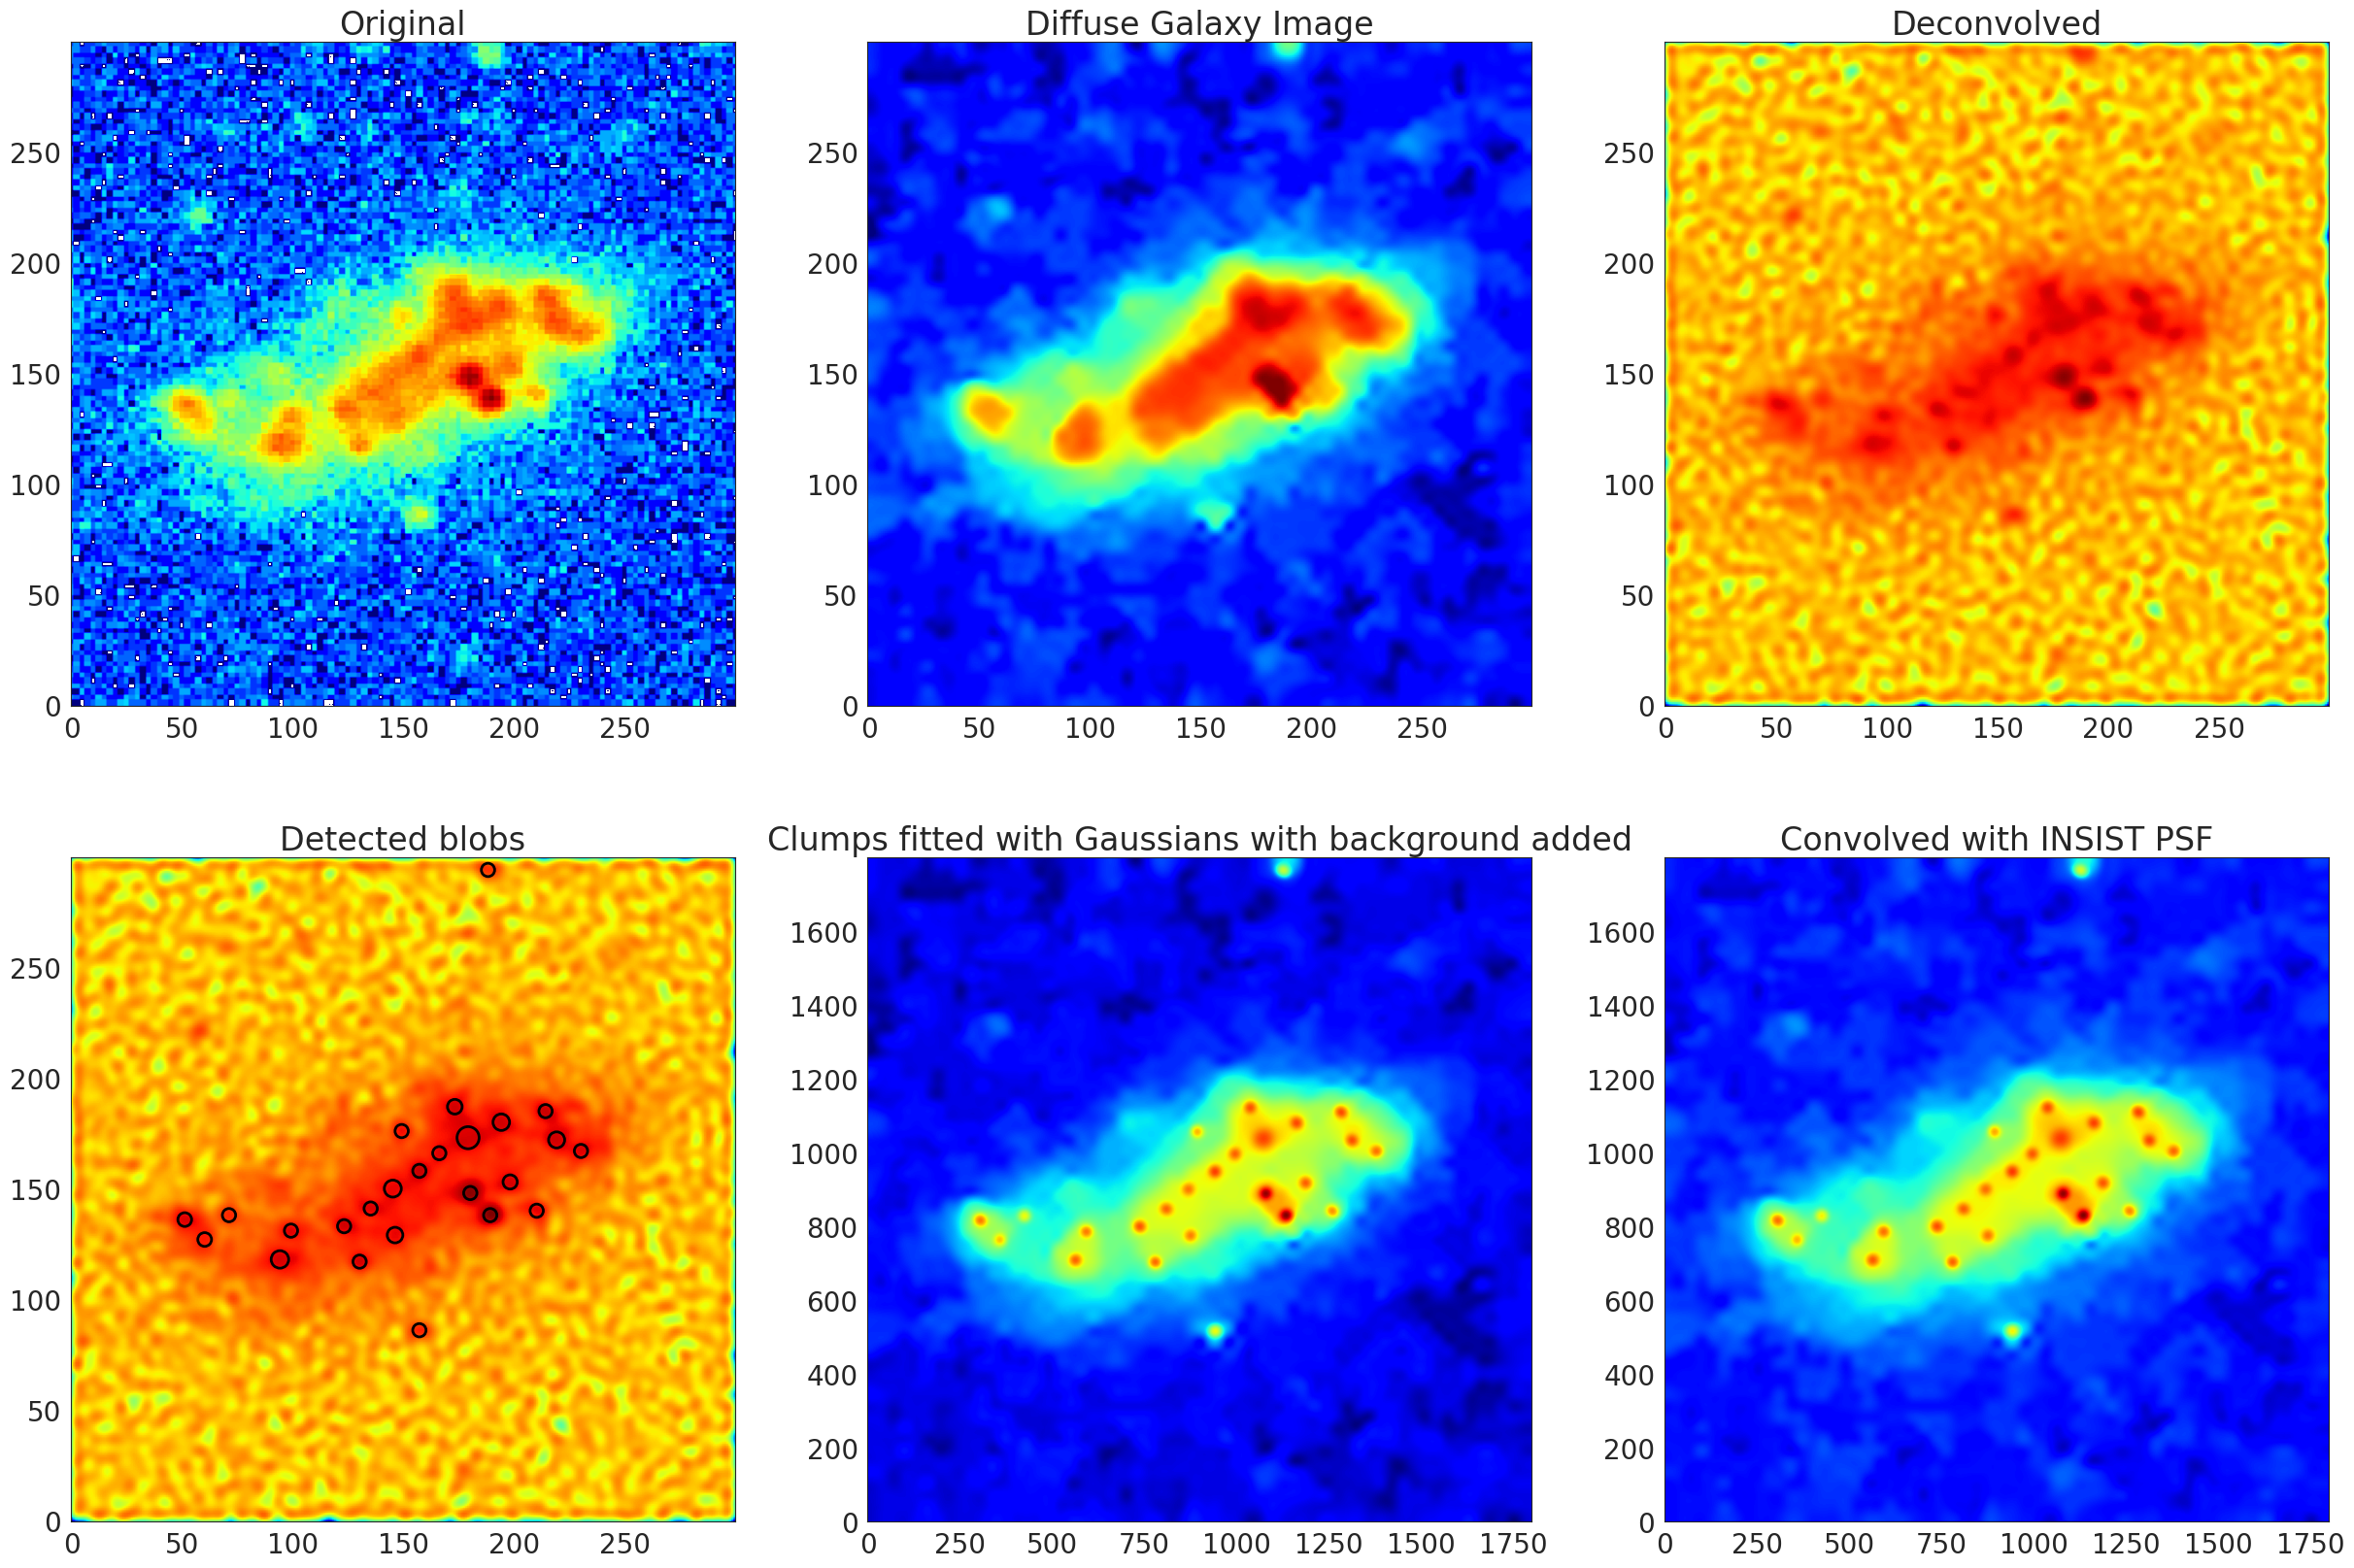

In [38]:
fig, ax = plt.subplots(2,3, figsize = (30,20))

ax[0,0].imshow(data , origin = 'lower', cmap = 'jet', norm = col.LogNorm())
ax[0,0].set_title('Original')
ax[0,0]

ax[0,1].imshow(bkg_image , origin = 'lower', cmap = 'jet', norm = col.LogNorm())
ax[0,1].set_title('Diffuse Galaxy Image')

ax[0,2].imshow(deconvolved_data , origin = 'lower', cmap = 'jet', norm = col.LogNorm())
ax[0,2].set_title('Deconvolved')

ax[1,0].imshow(image_data, origin = 'lower', cmap = 'jet', norm = col.LogNorm())
ax[1,0].set_title('Detected blobs')

for blob in blobs:
    y, x, r = blob
    c = plt.Circle((x, y), r, color="black", linewidth=2, fill=False)
    ax[1,0].add_patch(c)

ax[1,1].imshow(sim_img + bkg_img , origin = 'lower', cmap = 'jet', norm = col.LogNorm())
ax[1,1].set_title('Clumps fitted with Gaussians with background added')

ax[1,2].imshow(conv_img , origin = 'lower', cmap = 'jet', norm = col.LogNorm())
ax[1,2].set_title('Convolved with INSIST PSF')